# Examine Clusters

In [1]:
import os
from decouple import config
import fNeuro.second_level.second_level_functions as slf
import numpy as np
import pandas as pd
import ptitprince as pt
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import re
import statsmodels.api as sm
import scipy.stats as stats
from IPython.display import display
import ptitprince as pt
from statsmodels.stats.multitest import multipletests as multitest

Read in images and get parameter estimates

In [2]:
sig_clusters = ['eft_interaction', 'happy_interaction', 'fear_time']
parameter_estimates = {}
for task_contrast in sig_clusters:
    print('working on task and contrast: ', task_contrast)
    task = task_contrast.split('_')[0]
    contrast = task_contrast.split('_')[1]
    base_dir = config(task)
    path = os.path.join(base_dir, '2ndlevel')
    copes_dir = os.path.join(base_dir, '2ndlevel', 'mixed_model')
    parameter_estimates_df = slf.get_peak_voxel(base_dir, path, copes_dir, contrast)
    parameter_estimates[task_contrast] = parameter_estimates_df

working on task and contrast:  eft_interaction
working on task and contrast:  happy_interaction
working on task and contrast:  fear_time


## Plot and get mean of parameter estimates

Split parameter estimates by group and time point. Then get mean of each group and at in each time point

In [3]:
group_values={
    'an_t1': {},
    'an_t2': {},
    'hc_t1': {},
    'hc_t2': {}
}

for task_interaction in parameter_estimates.keys():
    print('Working on: ', task_interaction)
    an_t1 = parameter_estimates[task_interaction].loc[(parameter_estimates[task_interaction]['group'] == 'AN') 
                                                      & (parameter_estimates[task_interaction]['time_point'] == 't1')].iloc[:, 4:]
    an_t2 = parameter_estimates[task_interaction].loc[(parameter_estimates[task_interaction]['group'] == 'AN') 
                                                     & (parameter_estimates[task_interaction]['time_point'] == 't2')].iloc[:, 4:]    
    hc_t1 = parameter_estimates[task_interaction].loc[(parameter_estimates[task_interaction]['group'] == 'HC') 
                                                    & (parameter_estimates[task_interaction]['time_point'] == 't1')].iloc[:, 4:]
    hc_t2 = parameter_estimates[task_interaction].loc[(parameter_estimates[task_interaction]['group'] == 'HC') 
                                                    & (parameter_estimates[task_interaction]['time_point'] == 't2')].iloc[:, 4:]
    group_values['an_t1'][task_interaction] = [an_t1.mean(), an_t1.std()]
    group_values['an_t2'][task_interaction] = [an_t2.mean(), an_t2.std()]
    group_values['hc_t1'][task_interaction] = [hc_t1.mean(), hc_t1.std()]
    group_values['hc_t2'][task_interaction] = [hc_t2.mean(), hc_t2.std()]

Working on:  eft_interaction
Working on:  happy_interaction
Working on:  fear_time


In [4]:
means_std_df = pd.DataFrame(data={
    'AN T1 mean':  pd.concat((group_values['an_t1']['happy_interaction'][0], 
                              group_values['an_t1']['eft_interaction'][0], 
                              group_values['an_t1']['fear_time'][0])),
    'AN T1 std':  pd.concat((group_values['an_t1']['happy_interaction'][1], 
                             group_values['an_t1']['eft_interaction'][1], 
                             group_values['an_t1']['fear_time'][1])),
    'HC T1 mean':  pd.concat((group_values['hc_t1']['happy_interaction'][0], 
                              group_values['hc_t1']['eft_interaction'][0], 
                              group_values['hc_t1']['fear_time'][0])),
    'HC T1 std':  pd.concat((group_values['hc_t1']['happy_interaction'][1], 
                             group_values['hc_t1']['eft_interaction'][1], 
                             group_values['hc_t1']['fear_time'][1])),
    'AN T2 mean':  pd.concat((group_values['an_t2']['happy_interaction'][0], 
                              group_values['an_t2']['eft_interaction'][0], 
                              group_values['an_t2']['fear_time'][0])),
    'AN T2 std':  pd.concat((group_values['an_t2']['happy_interaction'][1], 
                             group_values['an_t2']['eft_interaction'][1], 
                             group_values['an_t2']['fear_time'][1])),
    'HC T2 mean':  pd.concat((group_values['hc_t2']['happy_interaction'][0], 
                              group_values['hc_t2']['eft_interaction'][0], 
                              group_values['hc_t2']['fear_time'][0])),
    'HC T2 std':  pd.concat((group_values['hc_t2']['happy_interaction'][1], 
                             group_values['hc_t2']['eft_interaction'][1], 
                             group_values['hc_t2']['fear_time'][1])),
                   }).T
means_std_df

,Vermis_4_5,Right_Frontal_Operculum_Cortex,Right_Frontal_Pole,Right_Planum_Temporale,Right_Putamen,Left_Precentral_Gyrus1,Left_Precentral_Gyrus2,Frontal_Sup_2_L
AN T1 mean,1.808552,3.164361,4.242870,1.868615,1.430196,5.701842,6.741921,1.065302
AN T1 std,1.771879,2.963295,5.291274,1.896685,1.021039,6.002200,6.937675,0.805804
HC T1 mean,2.971905,9.701787,13.826612,4.624110,2.742488,15.612160,17.317799,1.648148
HC T1 std,2.551519,14.884332,24.380634,5.393777,1.990463,20.673819,27.353666,1.741508
AN T2 mean,2.511060,7.554090,7.467186,2.797979,2.088970,13.617514,13.107894,1.543054
AN T2 std,2.332078,8.752158,10.988969,2.854433,1.781813,15.493722,14.074580,2.385784
HC T2 mean,1.221835,4.646283,5.083607,2.572464,1.520716,8.758195,8.423120,4.173595
HC T2 std,0.827403,5.575875,5.799491,3.242436,1.275471,7.461505,8.766540,5.511991


Plot parameter estimates

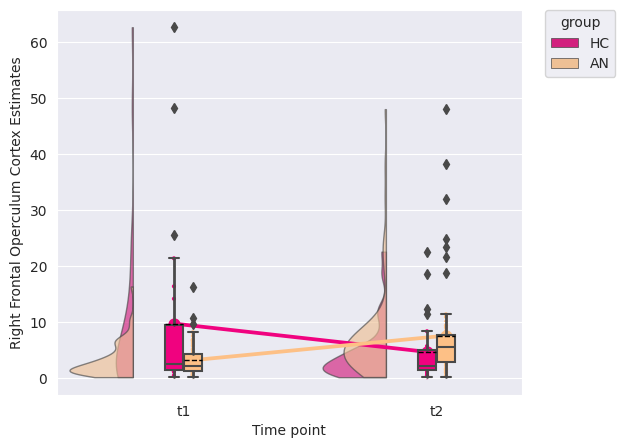

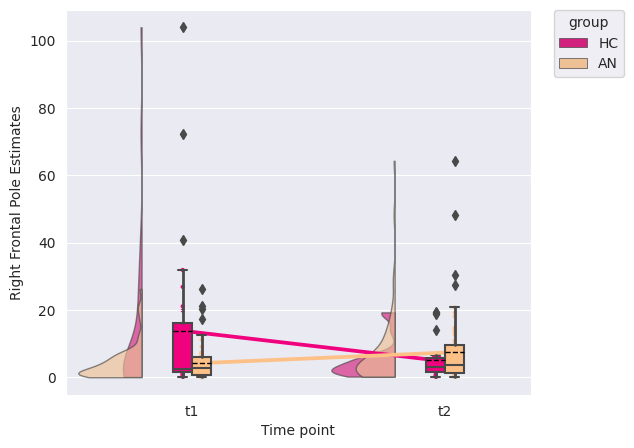

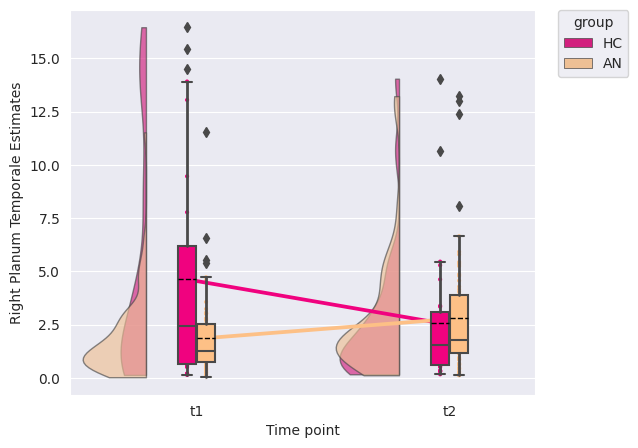

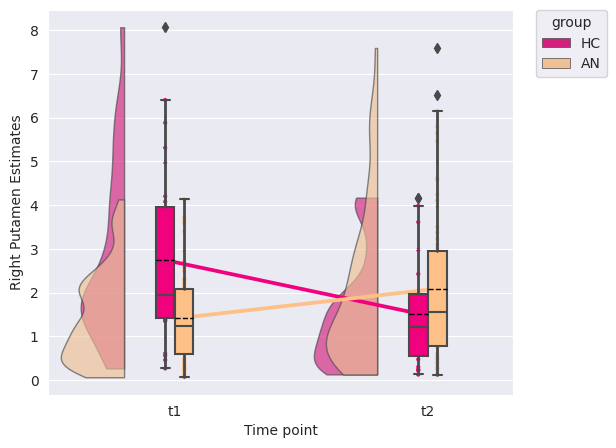

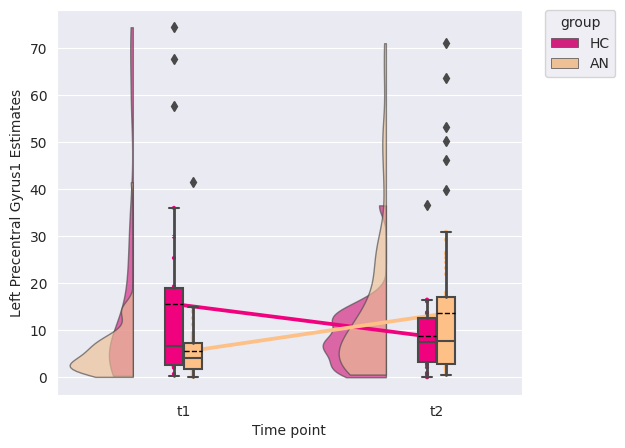

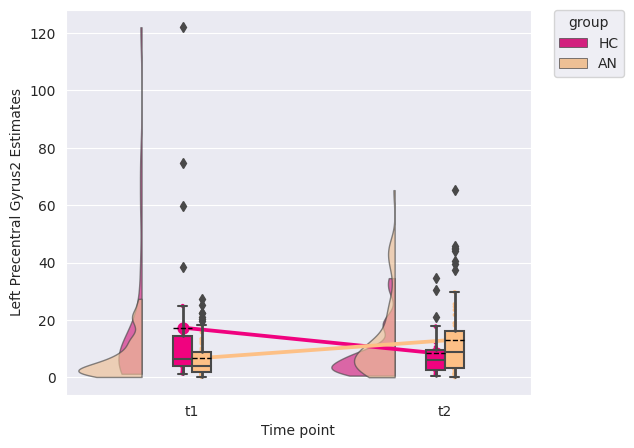

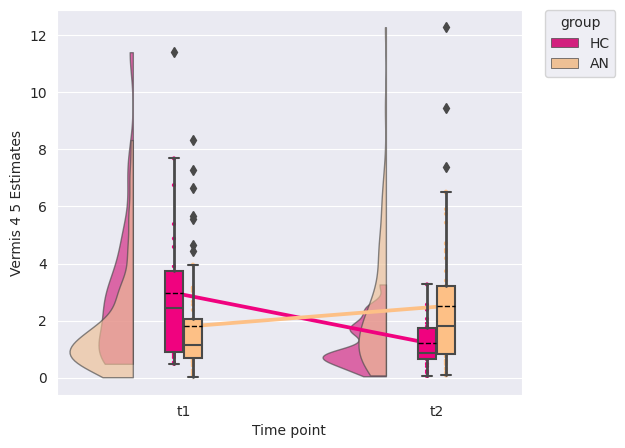

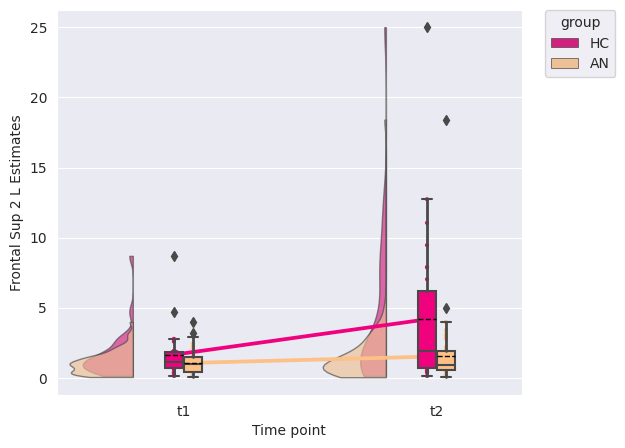

In [7]:
for task in parameter_estimates.keys():
    df = parameter_estimates[task].drop(['sub', 'time_point', 'id', 'group', ],axis=1)
    for cluster in df.columns:
        fig,ax = plt.subplots(1,1, figsize=(6, 5))
        pt.RainCloud(
            x="time_point", 
            y=cluster, 
            hue="group", 
            data=parameter_estimates[task], 
            palette='Accent_r', 
            alpha=.65, 
            dodge=True, 
            scale="area",
            ax=ax,
            width_viol=.5,
            jitter=0,
            pointplot = True,
            bw=.3,
            box_meanprops={"zorder" : 11, "color":"black"}, 
            box_meanline=True, 
            box_showmeans=True, 
            box_medianprops={"zorder": 11},
             )
        ax.set_ylabel(f'{" ".join(cluster.split("_"))} Estimates')
        ax.set_xlabel('Time point')
        plt.show()  


## Linear Mixed Model

Change reference level of model by changing the name of AN to participant with AN (pAN) and HC to Control

In [ ]:
neuroimaging_behavioural_measures = pd.read_csv(os.path.join(config('task_fmri'), 'neuroimaging_behavioural_measures.csv'))
beh_measures = pd.concat((
                        pd.melt(neuroimaging_behavioural_measures, id_vars='t1', value_vars=['edeq_global_score_t1', 'edeq_global_score_t2']).rename(columns={'value': 'edeq', 
                                                                                               'variable': 'time_point',
                                                                                               't1': 'subject'
                                                                                               }),
                        pd.melt(neuroimaging_behavioural_measures, id_vars='t1', value_vars=['anxiety_t1', 'anxiety_t2']).rename(columns={'value': 'hads_anxiety', 
                                                                                               })['hads_anxiety'],
                        pd.melt(neuroimaging_behavioural_measures, id_vars='t1', value_vars=['depression_t1', 'depression_t2']).rename(columns={'value': 'hads_depression', 
                                                                                               })['hads_depression'],
                        pd.melt(neuroimaging_behavioural_measures, id_vars='t1', value_vars=['bmi_t1', 'bmi_t2']).rename(columns={'value': 'bmi', 
                                                                                               })['bmi'],
                        pd.melt(neuroimaging_behavioural_measures, id_vars='t1', value_vars=['age_t1', 'age_t2']).rename(columns={'value': 'age', 
                                                                                               })['age'],

                        

), axis=1).sort_values(by='subject').reset_index(drop=True)
beh_measures['time_point'] = beh_measures['time_point'].apply(lambda time: 't1' if 'edeq_global_score_t1' in time else 't2')
beh_measures = beh_measures.drop(index=[164, 165])


In [ ]:
lmm = {}
for task_interaction in parameter_estimates.keys():
    parameter_estimates[task_interaction]['group'] = parameter_estimates[task_interaction]['group'].apply(lambda group: 'pAN' if group == 'AN' else 'Control')
    parameter_estimates[task_interaction]['id'] = parameter_estimates[task_interaction]['id'].apply(lambda id: re.sub('/ess_0004.nii', '', id))
    organised_df = pd.concat((parameter_estimates[task_interaction][parameter_estimates[task_interaction]['id'].str.contains('G')].sort_values(by='id', ascending=True),
                          parameter_estimates[task_interaction][parameter_estimates[task_interaction]['id'].str.contains('B')].sort_values(by='id', ascending=True))).reset_index(drop=True)
    lmm_df = pd.concat((beh_measures.sort_values(by=['time_point', 'subject']).reset_index(drop=True), 
                        organised_df.drop('time_point', axis=1)), axis=1).drop(['sub', 'id'], axis=1).sort_values(by='subject').reset_index(drop=True)
    lmm[task_interaction] = lmm_df

define and fit the model

In [ ]:
from IPython.display import display

for task in lmm.keys():
    for cluster in lmm[task].drop(['subject', 'time_point', 'edeq', 'hads_anxiety', 'hads_depression', 'bmi', 'age', 'group', ],axis=1).columns:
    
        model = smf.mixedlm(f"{cluster} ~ time_point + group + group*time_point", 
                            lmm[task], 
                            groups=lmm[task]["subject"]).fit()
        model.summary()
        summ = pd.concat((model.params.to_frame().T.rename(index={0: 'params'}), 
                   model.bse_fe.to_frame().T.rename(index={0: 'std'}),
                   model.conf_int().T.drop('Group Var', axis=1).rename(index={0: 'CI_0.025', 1: 'CI_0.975'}))).dropna(axis=1)
        print('-'*100)
        print(cluster)
        display(summ)

----------------------------------------------------------------------------------------------------
Right_Frontal_Operculum_Cortex


,Intercept,time_point[T.t2],group[T.pAN],group[T.pAN]:time_point[T.t2]
params,9.701787,-5.055503,-6.537426,9.445232
std,1.573501,2.182521,1.871993,2.596544
CI_0.025,6.617782,-9.333166,-10.206465,4.356099
CI_0.975,12.785792,-0.777841,-2.868387,14.534365


----------------------------------------------------------------------------------------------------
Right_Frontal_Pole


,Intercept,time_point[T.t2],group[T.pAN],group[T.pAN]:time_point[T.t2]
params,13.826612,-8.743005,-9.583742,11.967322
std,2.306265,3.142757,2.743762,3.738936
CI_0.025,9.306416,-14.902695,-14.961417,4.639142
CI_0.975,18.346809,-2.583315,-4.206067,19.295501


----------------------------------------------------------------------------------------------------
Right_Planum_Temporale


/home/k1812017/.conda/envs/neuroimaging/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


,Intercept,time_point[T.t2],group[T.pAN],group[T.pAN]:time_point[T.t2]
params,4.624110,-2.051646,-2.755494,2.981010
std,0.605437,0.856218,0.720289,1.018642
CI_0.025,3.437474,-3.729802,-4.167234,0.984508
CI_0.975,5.810745,-0.373490,-1.343755,4.977511


----------------------------------------------------------------------------------------------------
Right_Putamen


,Intercept,time_point[T.t2],group[T.pAN],group[T.pAN]:time_point[T.t2]
params,2.742488,-1.221772,-1.312292,1.880547
std,0.292295,0.410038,0.347743,0.487822
CI_0.025,2.169601,-2.025431,-1.993856,0.924433
CI_0.975,3.315376,-0.418113,-0.630728,2.836660


----------------------------------------------------------------------------------------------------
Left_Precentral_Gyrus1


/home/k1812017/.conda/envs/neuroimaging/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


,Intercept,time_point[T.t2],group[T.pAN],group[T.pAN]:time_point[T.t2]
params,15.612159,-6.853963,-9.910318,14.769635
std,2.493998,3.527031,2.967108,4.196106
CI_0.025,10.724012,-13.766817,-15.725743,6.545418
CI_0.975,20.500306,0.058890,-4.094892,22.993853


----------------------------------------------------------------------------------------------------
Left_Precentral_Gyrus2


,Intercept,time_point[T.t2],group[T.pAN],group[T.pAN]:time_point[T.t2]
params,17.317799,-8.894680,-10.575879,15.260652
std,2.767030,3.708128,3.291934,4.411558
CI_0.025,11.894521,-16.162478,-17.027950,6.614157
CI_0.975,22.741078,-1.626882,-4.123807,23.907147


----------------------------------------------------------------------------------------------------
Vermis_4_5


,Intercept,time_point[T.t2],group[T.pAN],group[T.pAN]:time_point[T.t2]
params,2.971905,-1.750070,-1.163353,2.452579
std,0.389171,0.523789,0.462997,0.623152
CI_0.025,2.209143,-2.776678,-2.070810,1.231224
CI_0.975,3.734666,-0.723461,-0.255897,3.673934


----------------------------------------------------------------------------------------------------
Frontal_Sup_2_L


,Intercept,time_point[T.t2],group[T.pAN],group[T.pAN]:time_point[T.t2]
params,1.648148,2.525447,-0.582846,-2.047695
std,0.512123,0.710913,0.609272,0.845773
CI_0.025,0.644406,1.132082,-1.776998,-3.705379
CI_0.975,2.651891,3.918811,0.611306,-0.390010


In [ ]:
lmm_models = {}
for task in lmm.keys():
    for cluster in lmm[task].drop(['subject', 'time_point', 'edeq', 'hads_anxiety', 'hads_depression', 'bmi', 'age', 'group', ],axis=1).columns:
        lmm[task]['cluster_trans'] = np.log10(lmm[task][cluster])
        cluster_model = smf.mixedlm("""
                    cluster_trans ~ edeq + hads_anxiety + hads_depression + bmi + age + time_point 
                    + edeq:time_point + hads_anxiety:time_point + hads_depression:time_point + bmi:time_point + age:time_point
                    """, groups='subject' , data=lmm[task][lmm[task]['subject'].str.contains('G2')].reset_index(drop=True).dropna()).fit()
        lmm_models[f'{task}_{cluster}'] = cluster_model

/home/k1812017/.conda/envs/neuroimaging/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/k1812017/.conda/envs/neuroimaging/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/k1812017/.conda/envs/neuroimaging/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [ ]:
fwe = {
    'intercept_fwe': multitest([lmm_models[cluster].pvalues['Intercept'] for cluster in lmm_models.keys()], method='fdr_tsbh'),
    'time_fwe': multitest([lmm_models[cluster].pvalues['time_point[T.t2]'] for cluster in lmm_models.keys()], method='fdr_tsbh'),
    'edeq_fwe': multitest([lmm_models[cluster].pvalues['edeq'] for cluster in lmm_models.keys()], method='fdr_tsbh'),
    'edeq_interaction_fwe': multitest([lmm_models[cluster].pvalues['edeq:time_point[T.t2]'] for cluster in lmm_models.keys()], method='fdr_tsbh'),
    'hads_anxiety_fwe': multitest([lmm_models[cluster].pvalues['hads_anxiety'] for cluster in lmm_models.keys()], method='fdr_tsbh'),
    'hads_anxiety_interaction_fwe': multitest([lmm_models[cluster].pvalues['hads_anxiety:time_point[T.t2]'] for cluster in lmm_models.keys()], method='fdr_tsbh'),
    'hads_depression_fwe': multitest([lmm_models[cluster].pvalues['hads_depression'] for cluster in lmm_models.keys()], method='fdr_tsbh'),
    'hads_depression_interaction_fwe': multitest([lmm_models[cluster].pvalues['hads_depression:time_point[T.t2]'] for cluster in lmm_models.keys()], method='fdr_tsbh'),
    'bmi_fwe': multitest([lmm_models[cluster].pvalues['bmi'] for cluster in lmm_models.keys()], method='fdr_tsbh'),
    'bmi_interaction_fwe': multitest([lmm_models[cluster].pvalues['bmi:time_point[T.t2]'] for cluster in lmm_models.keys()], method='fdr_tsbh'),
    'age_fwe': multitest([lmm_models[cluster].pvalues['age'] for cluster in lmm_models.keys()], method='fdr_tsbh'),
    'age_interaction_fwe': multitest([lmm_models[cluster].pvalues['age:time_point[T.t2]'] for cluster in lmm_models.keys()], method='fdr_tsbh')
}
for fwe_correction in fwe:
    if True in fwe[fwe_correction][0]:
        print(fwe_correction, fwe[fwe_correction])

In [ ]:
def r2(cluster_model, df) -> dict:
    var_resid = cluster_model.scale
    var_random_effect = float(cluster_model.cov_re.iloc[0])
    var_fixed_effect = cluster_model.predict(df[df['subject'].str.contains('G2')].reset_index(drop=True).dropna()).var()
    total_var = var_fixed_effect + var_random_effect + var_resid
    marginal_r2 = var_fixed_effect / total_var
    conditional_r2 = (var_fixed_effect + var_random_effect) / total_var
    return {'conditional_r2': conditional_r2,
                'marginal_r2': marginal_r2}

eft_interaction_Right_Frontal_Operculum_Cortex


NormaltestResult(statistic=2.509448041885478, pvalue=0.28515453404561436)

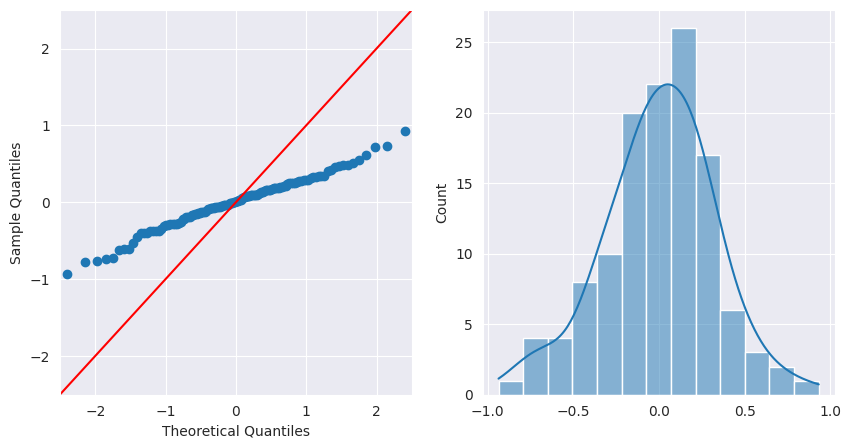

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
===========================================================================
Model:                  MixedLM      Dependent Variable:      cluster_trans
No. Observations:       124          Method:                  REML         
No. Groups:             65           Scale:                   0.1445       
Min. group size:        1            Log-Likelihood:          -97.6536     
Max. group size:        2            Converged:               Yes          
Mean group size:        1.9                                                
---------------------------------------------------------------------------
                                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                        -0.331    0.522 -0.634 0.526 -1.355  0.693
time_point[T.t2]                  0.724    0.671  1.080 0.280 -0.590  2.039
edeq                              0.026    0.038  0.687 0.492 -0.048  0.100
edeq:time_point[T.t2]            -0.072    0.057 -1.258 0.208 -0.183  0.040
hads_anxiety                     -0.030    0.018 -1.695 0.090 -0.064  0.005
hads_anxiety:time_point[T.t2]     0.053    0.023  2.355 0.019  0.009  0.098
hads_depression                   0.019    0.019  1.004 0.316 -0.018  0.057
hads_depression:time_point[T.t2] -0.011    0.025 -0.442 0.659 -0.059  0.038
bmi                               0.014    0.021  0.679 0.497 -0.027  0.055
bmi:time_point[T.t2]              0.013    0.025  0.536 0.592 -0.036  0.062
age                               0.026    0.017  1.546 0.122 -0.007  0.060
age:time_point[T.t2]             -0.048    0.021 -2.296 0.022 -0.089 -0.007
subject Var                       0.039    0.081                           
===========================================================================

"""

marginal_r2:  0.21881855572446426 

----------------------------------------------------------------------------------------------------
eft_interaction_Right_Frontal_Pole


NormaltestResult(statistic=2.2858681822563547, pvalue=0.31888201895986723)

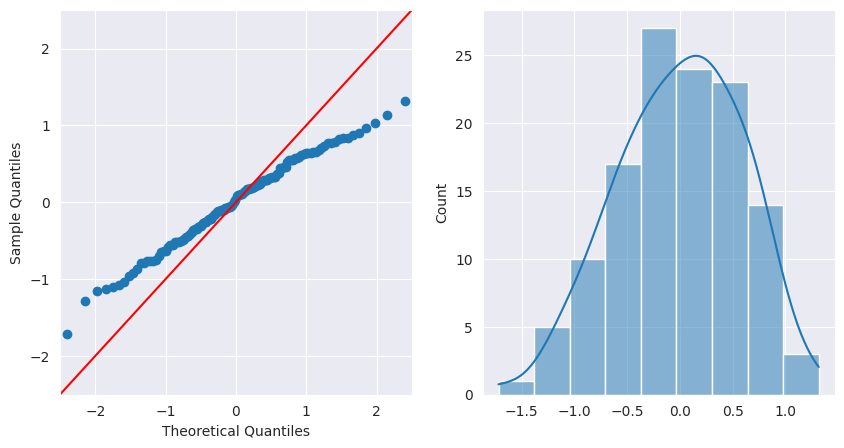

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
===========================================================================
Model:                  MixedLM      Dependent Variable:      cluster_trans
No. Observations:       124          Method:                  REML         
No. Groups:             65           Scale:                   0.3783       
Min. group size:        1            Log-Likelihood:          -139.4411    
Max. group size:        2            Converged:               Yes          
Mean group size:        1.9                                                
---------------------------------------------------------------------------
                                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                         0.084    0.783  0.107 0.915 -1.450  1.617
time_point[T.t2]                 -0.110    1.082 -0.102 0.919 -2.230  2.010
edeq                              0.081    0.055  1.473 0.141 -0.027  0.189
edeq:time_point[T.t2]            -0.114    0.088 -1.301 0.193 -0.285  0.058
hads_anxiety                     -0.028    0.026 -1.079 0.280 -0.078  0.023
hads_anxiety:time_point[T.t2]     0.036    0.035  1.050 0.294 -0.032  0.105
hads_depression                   0.014    0.028  0.491 0.623 -0.041  0.069
hads_depression:time_point[T.t2] -0.032    0.037 -0.852 0.394 -0.104  0.041
bmi                              -0.008    0.031 -0.269 0.788 -0.070  0.053
bmi:time_point[T.t2]              0.026    0.040  0.657 0.511 -0.052  0.104
age                               0.015    0.025  0.609 0.542 -0.033  0.064
age:time_point[T.t2]             -0.000    0.033 -0.004 0.997 -0.066  0.065
subject Var                       0.000    0.092                           
===========================================================================

"""

marginal_r2:  0.0872791560684446 

----------------------------------------------------------------------------------------------------
eft_interaction_Right_Planum_Temporale


NormaltestResult(statistic=8.31130303261541, pvalue=0.01567557490927931)

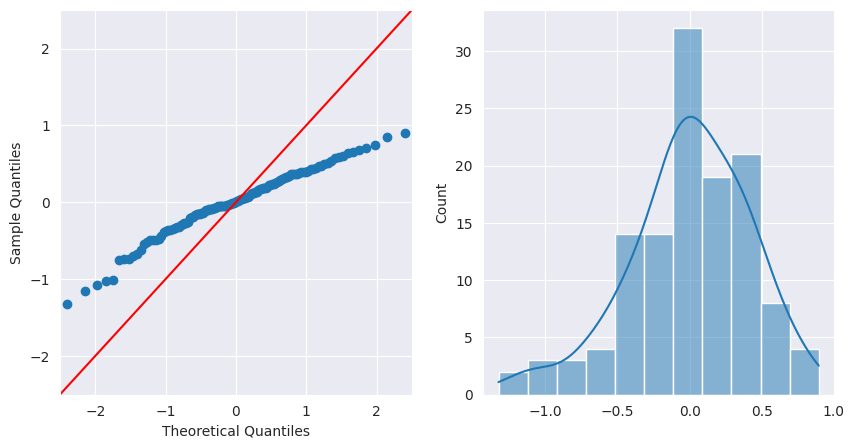

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
===========================================================================
Model:                  MixedLM      Dependent Variable:      cluster_trans
No. Observations:       124          Method:                  REML         
No. Groups:             65           Scale:                   0.2080       
Min. group size:        1            Log-Likelihood:          -108.9087    
Max. group size:        2            Converged:               Yes          
Mean group size:        1.9                                                
---------------------------------------------------------------------------
                                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                         0.379    0.584  0.649 0.516 -0.765  1.523
time_point[T.t2]                 -0.667    0.802 -0.832 0.405 -2.238  0.904
edeq                             -0.054    0.042 -1.291 0.197 -0.137  0.028
edeq:time_point[T.t2]             0.113    0.066  1.712 0.087 -0.016  0.241
hads_anxiety                     -0.001    0.020 -0.026 0.979 -0.039  0.038
hads_anxiety:time_point[T.t2]    -0.013    0.026 -0.506 0.613 -0.063  0.037
hads_depression                   0.005    0.021  0.216 0.829 -0.037  0.046
hads_depression:time_point[T.t2] -0.011    0.028 -0.388 0.698 -0.066  0.044
bmi                               0.005    0.024  0.205 0.838 -0.041  0.051
bmi:time_point[T.t2]              0.021    0.030  0.686 0.492 -0.038  0.079
age                              -0.013    0.019 -0.714 0.475 -0.050  0.023
age:time_point[T.t2]              0.018    0.025  0.721 0.471 -0.031  0.067
subject Var                       0.012    0.069                           
===========================================================================

"""

marginal_r2:  0.07934910640951096 

----------------------------------------------------------------------------------------------------
eft_interaction_Right_Putamen


NormaltestResult(statistic=5.556955522425106, pvalue=0.06213301671424279)

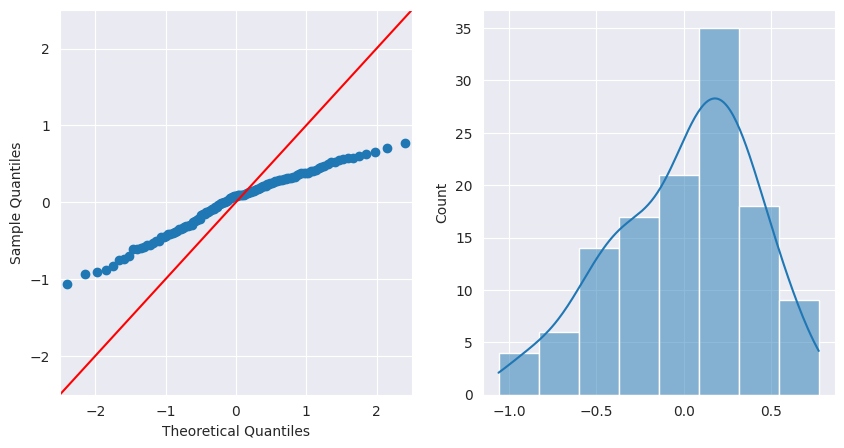

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
===========================================================================
Model:                  MixedLM      Dependent Variable:      cluster_trans
No. Observations:       124          Method:                  REML         
No. Groups:             65           Scale:                   0.1784       
Min. group size:        1            Log-Likelihood:          -98.3509     
Max. group size:        2            Converged:               Yes          
Mean group size:        1.9                                                
---------------------------------------------------------------------------
                                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                        -0.649    0.523 -1.242 0.214 -1.674  0.376
time_point[T.t2]                  0.864    0.728  1.186 0.236 -0.564  2.291
edeq                             -0.033    0.038 -0.854 0.393 -0.107  0.042
edeq:time_point[T.t2]             0.038    0.061  0.622 0.534 -0.081  0.157
hads_anxiety                     -0.008    0.018 -0.448 0.654 -0.043  0.027
hads_anxiety:time_point[T.t2]    -0.001    0.024 -0.043 0.966 -0.047  0.045
hads_depression                   0.032    0.020  1.635 0.102 -0.006  0.071
hads_depression:time_point[T.t2] -0.007    0.026 -0.288 0.774 -0.057  0.043
bmi                               0.033    0.021  1.560 0.119 -0.008  0.074
bmi:time_point[T.t2]             -0.030    0.027 -1.110 0.267 -0.083  0.023
age                              -0.000    0.017 -0.003 0.998 -0.034  0.034
age:time_point[T.t2]             -0.009    0.023 -0.406 0.685 -0.054  0.036
subject Var                       0.003    0.059                           
===========================================================================

"""

marginal_r2:  0.08516868424910533 

----------------------------------------------------------------------------------------------------
eft_interaction_Left_Precentral_Gyrus1


NormaltestResult(statistic=1.8110614613772347, pvalue=0.4043272392743661)

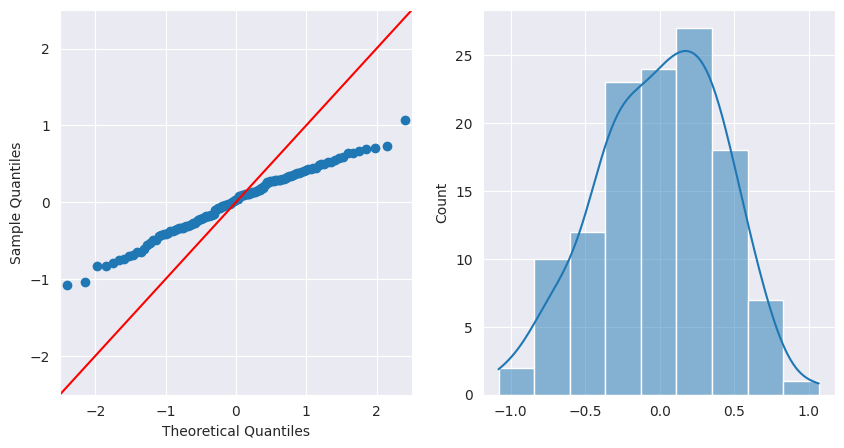

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
===========================================================================
Model:                  MixedLM      Dependent Variable:      cluster_trans
No. Observations:       124          Method:                  REML         
No. Groups:             65           Scale:                   0.2031       
Min. group size:        1            Log-Likelihood:          -108.5707    
Max. group size:        2            Converged:               Yes          
Mean group size:        1.9                                                
---------------------------------------------------------------------------
                                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                         0.781    0.577  1.352 0.176 -0.351  1.912
time_point[T.t2]                  0.283    0.791  0.358 0.720 -1.267  1.834
edeq                             -0.021    0.042 -0.500 0.617 -0.104  0.062
edeq:time_point[T.t2]            -0.053    0.065 -0.819 0.413 -0.181  0.074
hads_anxiety                      0.008    0.020  0.395 0.693 -0.031  0.046
hads_anxiety:time_point[T.t2]    -0.017    0.026 -0.678 0.498 -0.068  0.033
hads_depression                  -0.000    0.022 -0.005 0.996 -0.044  0.043
hads_depression:time_point[T.t2]  0.015    0.029  0.531 0.595 -0.041  0.072
bmi                               0.023    0.023  1.003 0.316 -0.022  0.069
bmi:time_point[T.t2]             -0.006    0.030 -0.194 0.846 -0.064  0.052
age                              -0.035    0.019 -1.858 0.063 -0.071  0.002
age:time_point[T.t2]              0.021    0.025  0.839 0.401 -0.027  0.069
subject Var                       0.015    0.075                           
===========================================================================

"""

marginal_r2:  0.18281523869946997 

----------------------------------------------------------------------------------------------------
eft_interaction_Left_Precentral_Gyrus2


NormaltestResult(statistic=14.39835325526849, pvalue=0.0007472007796403911)

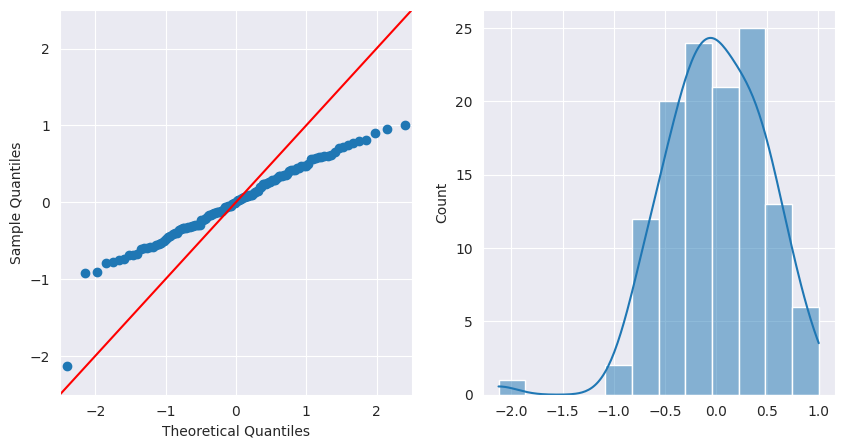

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
===========================================================================
Model:                  MixedLM      Dependent Variable:      cluster_trans
No. Observations:       124          Method:                  REML         
No. Groups:             65           Scale:                   0.2573       
Min. group size:        1            Log-Likelihood:          -117.8475    
Max. group size:        2            Converged:               Yes          
Mean group size:        1.9                                                
---------------------------------------------------------------------------
                                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                        -0.827    0.622 -1.329 0.184 -2.047  0.392
time_point[T.t2]                  1.709    0.870  1.963 0.050  0.002  3.415
edeq                              0.091    0.046  1.994 0.046  0.002  0.180
edeq:time_point[T.t2]            -0.049    0.073 -0.676 0.499 -0.191  0.093
hads_anxiety                     -0.026    0.021 -1.222 0.222 -0.067  0.016
hads_anxiety:time_point[T.t2]    -0.007    0.028 -0.257 0.797 -0.062  0.048
hads_depression                  -0.006    0.023 -0.244 0.807 -0.051  0.040
hads_depression:time_point[T.t2]  0.021    0.030  0.704 0.481 -0.038  0.081
bmi                               0.057    0.025  2.260 0.024  0.007  0.106
bmi:time_point[T.t2]             -0.019    0.032 -0.581 0.561 -0.082  0.044
age                               0.022    0.020  1.098 0.272 -0.018  0.062
age:time_point[T.t2]             -0.049    0.027 -1.768 0.077 -0.103  0.005
subject Var                       0.000    0.071                           
===========================================================================

"""

marginal_r2:  0.1842880958008606 

----------------------------------------------------------------------------------------------------
happy_interaction_Vermis_4_5


NormaltestResult(statistic=8.265708113589682, pvalue=0.01603704281340459)

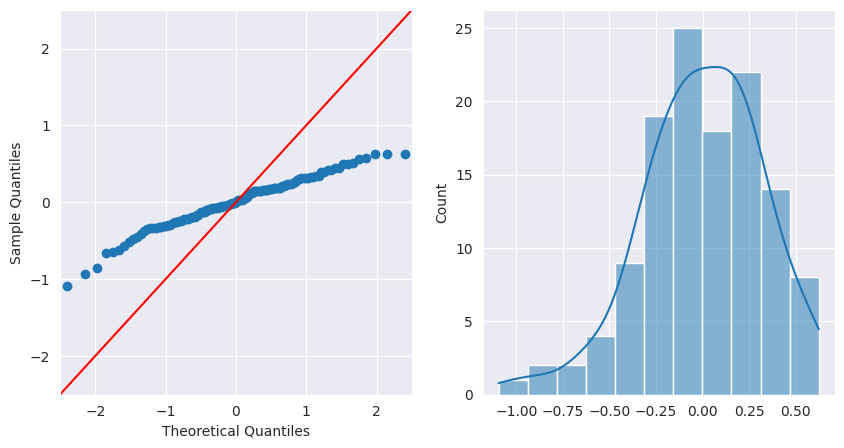

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
===========================================================================
Model:                  MixedLM      Dependent Variable:      cluster_trans
No. Observations:       124          Method:                  REML         
No. Groups:             65           Scale:                   0.1489       
Min. group size:        1            Log-Likelihood:          -103.4481    
Max. group size:        2            Converged:               Yes          
Mean group size:        1.9                                                
---------------------------------------------------------------------------
                                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                         0.110    0.551  0.199 0.843 -0.971  1.190
time_point[T.t2]                  0.215    0.686  0.313 0.754 -1.130  1.560
edeq                              0.017    0.041  0.414 0.679 -0.063  0.097
edeq:time_point[T.t2]             0.032    0.060  0.536 0.592 -0.085  0.149
hads_anxiety                     -0.005    0.018 -0.288 0.774 -0.041  0.031
hads_anxiety:time_point[T.t2]    -0.010    0.024 -0.404 0.686 -0.056  0.037
hads_depression                   0.037    0.021  1.803 0.071 -0.003  0.077
hads_depression:time_point[T.t2] -0.033    0.026 -1.265 0.206 -0.083  0.018
bmi                               0.019    0.022  0.851 0.395 -0.025  0.063
bmi:time_point[T.t2]             -0.009    0.026 -0.350 0.727 -0.059  0.041
age                              -0.036    0.018 -1.968 0.049 -0.071 -0.000
age:time_point[T.t2]              0.023    0.021  1.064 0.287 -0.019  0.065
subject Var                       0.057    0.099                           
===========================================================================

"""

marginal_r2:  0.10079471139566963 

----------------------------------------------------------------------------------------------------
fear_time_Frontal_Sup_2_L


NormaltestResult(statistic=5.0821936091035935, pvalue=0.07877994618442194)

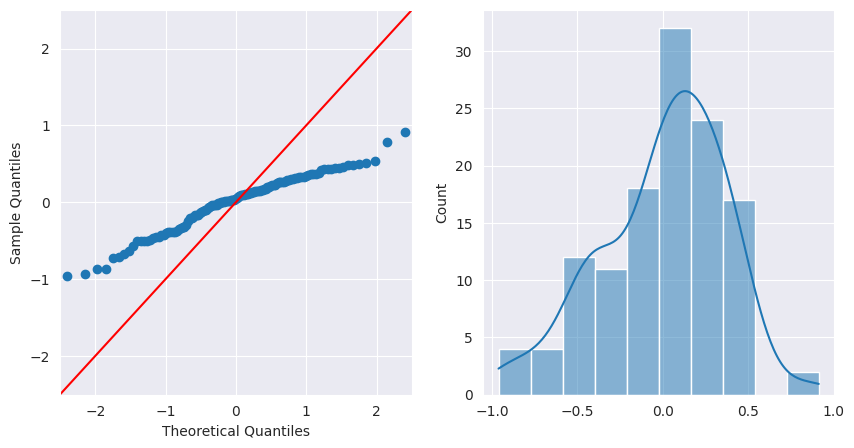

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
===========================================================================
Model:                  MixedLM      Dependent Variable:      cluster_trans
No. Observations:       124          Method:                  REML         
No. Groups:             65           Scale:                   0.1733       
Min. group size:        1            Log-Likelihood:          -106.2769    
Max. group size:        2            Converged:               Yes          
Mean group size:        1.9                                                
---------------------------------------------------------------------------
                                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                        -0.125    0.564 -0.221 0.825 -1.231  0.981
time_point[T.t2]                  1.312    0.733  1.790 0.073 -0.125  2.749
edeq                              0.059    0.041  1.456 0.145 -0.021  0.139
edeq:time_point[T.t2]            -0.062    0.062 -0.994 0.320 -0.183  0.060
hads_anxiety                     -0.010    0.019 -0.515 0.606 -0.047  0.028
hads_anxiety:time_point[T.t2]    -0.003    0.025 -0.120 0.905 -0.052  0.046
hads_depression                   0.015    0.021  0.715 0.474 -0.026  0.055
hads_depression:time_point[T.t2] -0.016    0.027 -0.603 0.547 -0.068  0.036
bmi                              -0.006    0.023 -0.285 0.775 -0.051  0.038
bmi:time_point[T.t2]             -0.012    0.027 -0.452 0.651 -0.066  0.041
age                              -0.006    0.018 -0.310 0.756 -0.042  0.030
age:time_point[T.t2]             -0.027    0.023 -1.195 0.232 -0.072  0.017
subject Var                       0.039    0.081                           
===========================================================================

"""

marginal_r2:  0.08372289493277847 

----------------------------------------------------------------------------------------------------


In [ ]:
for cluster_model in lmm_models.keys():
    print(cluster_model)
    display(stats.normaltest(lmm_models[cluster_model].resid))
    fig, ax = plt.subplots(1, 2,figsize=(10, 5))
    fig = sm.qqplot(lmm_models[cluster_model].resid, line='45', ax=ax[0])
    sns.histplot(lmm_models[cluster_model].resid, ax=ax[1],  kde=True)
    plt.show()
    display(lmm_models[cluster_model].summary())
    task_cluster = cluster_model.split('_')
    task = task_cluster[0] + '_' + task_cluster[1]
    cluster = re.sub(task, '', cluster_model).lstrip('_')
    r2_models = r2(lmm_models[cluster_model], lmm[task][['subject', 'time_point', 'edeq', 'hads_anxiety', 'hads_depression', 'bmi', 'age', 'group', cluster]])
    print('marginal_r2: ', r2_models['marginal_r2'], '\n')
    print('-'*100)

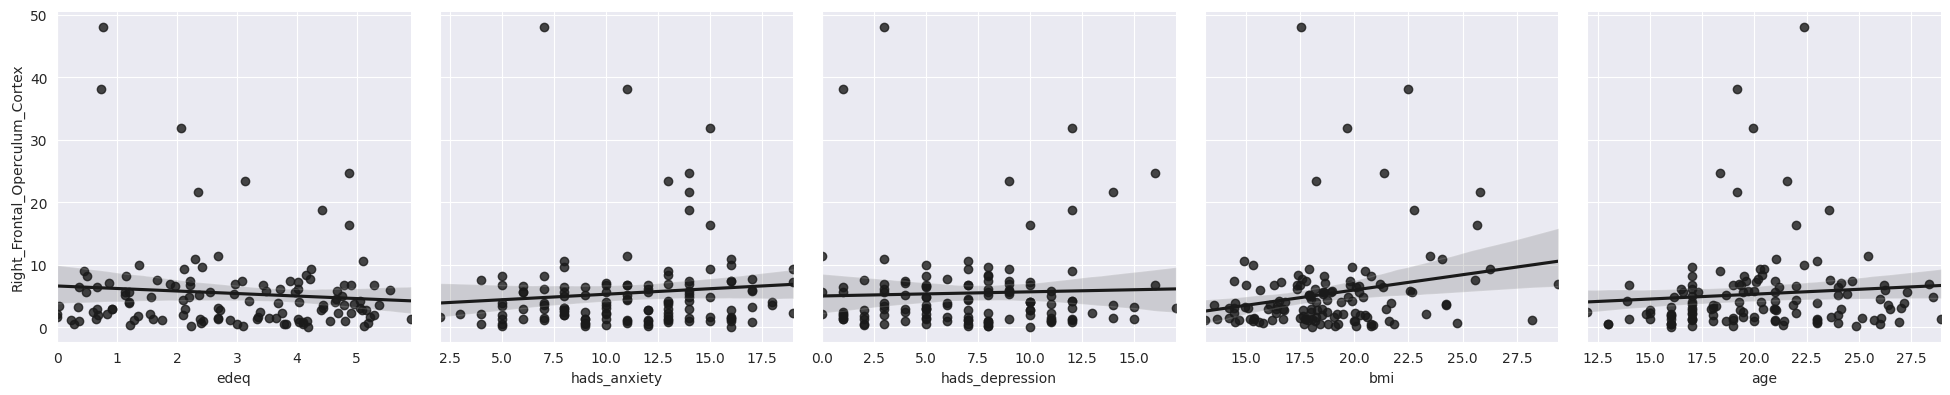

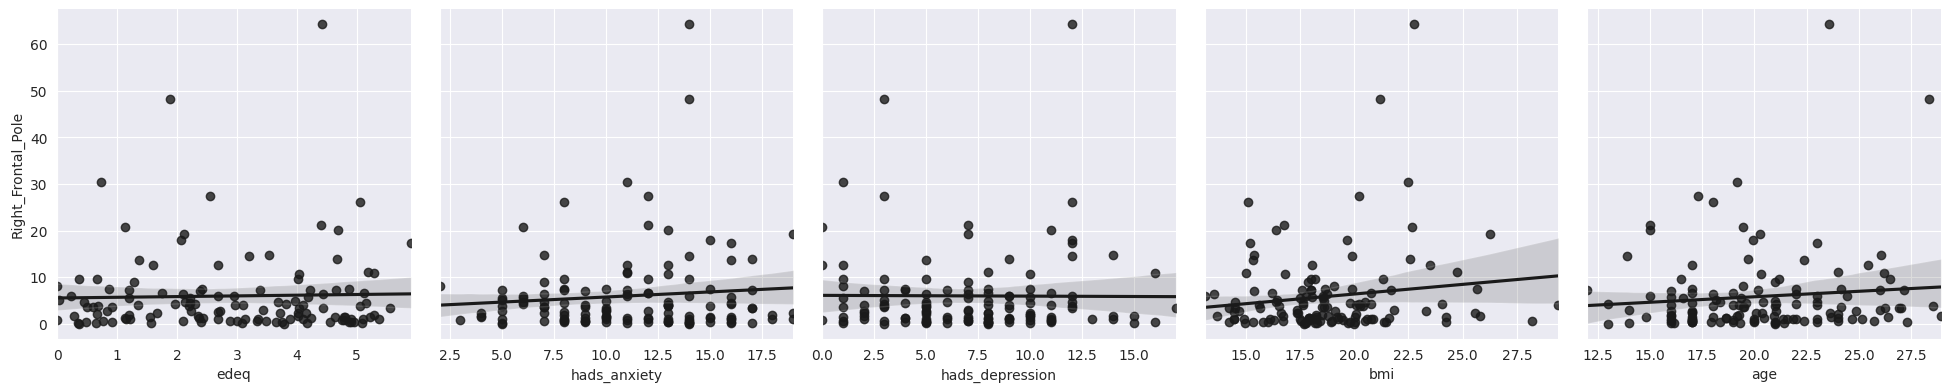

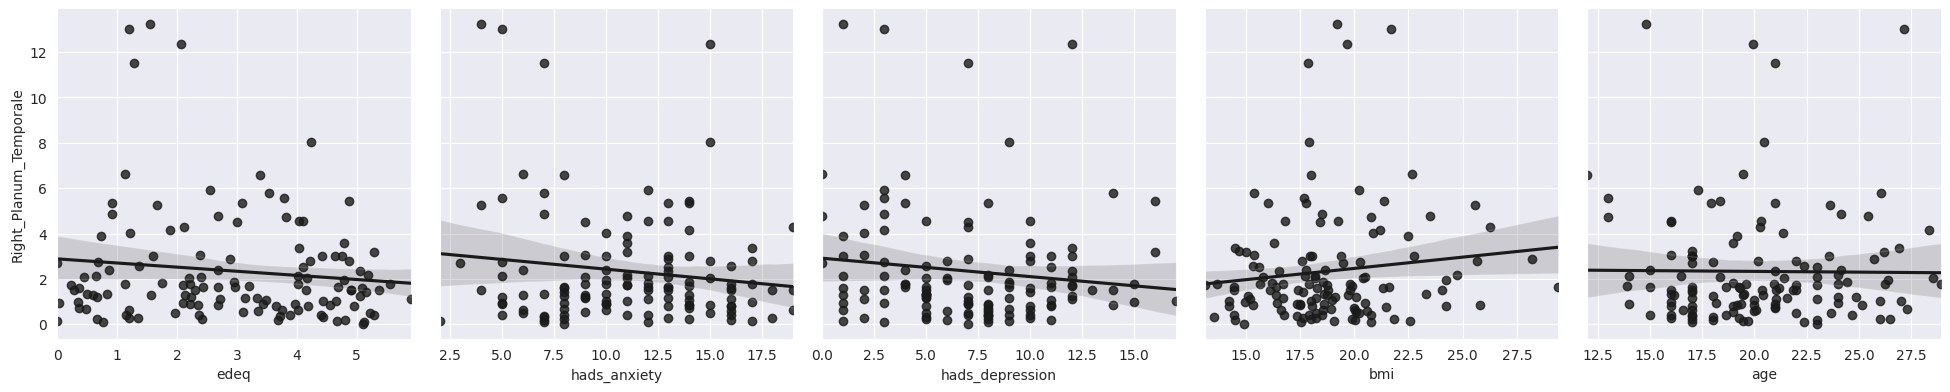

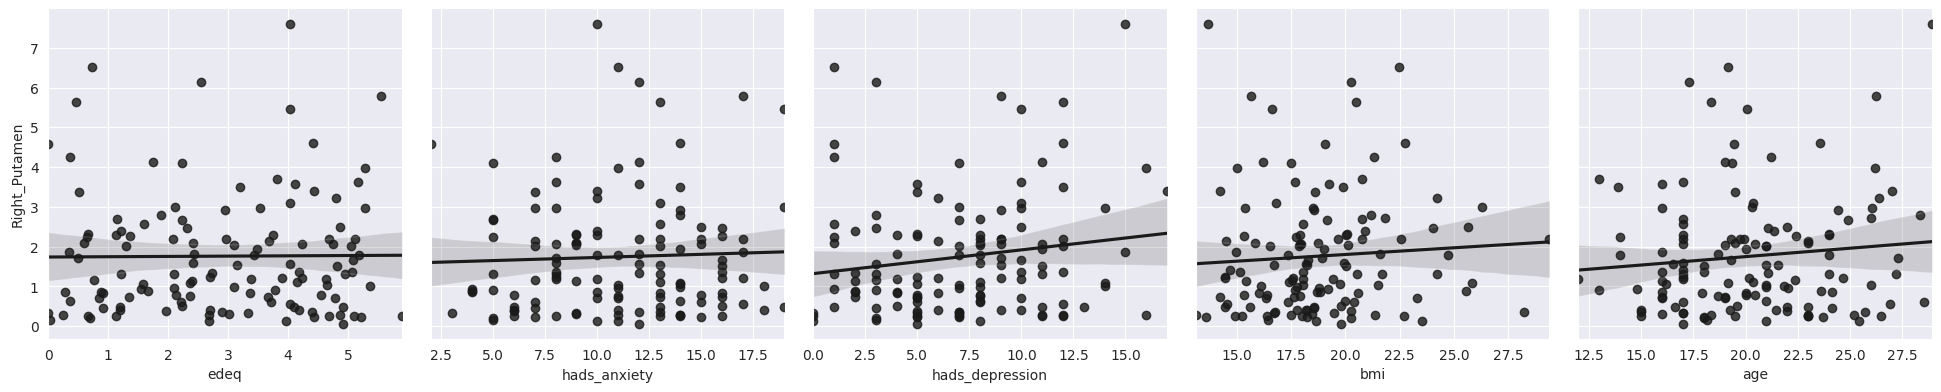

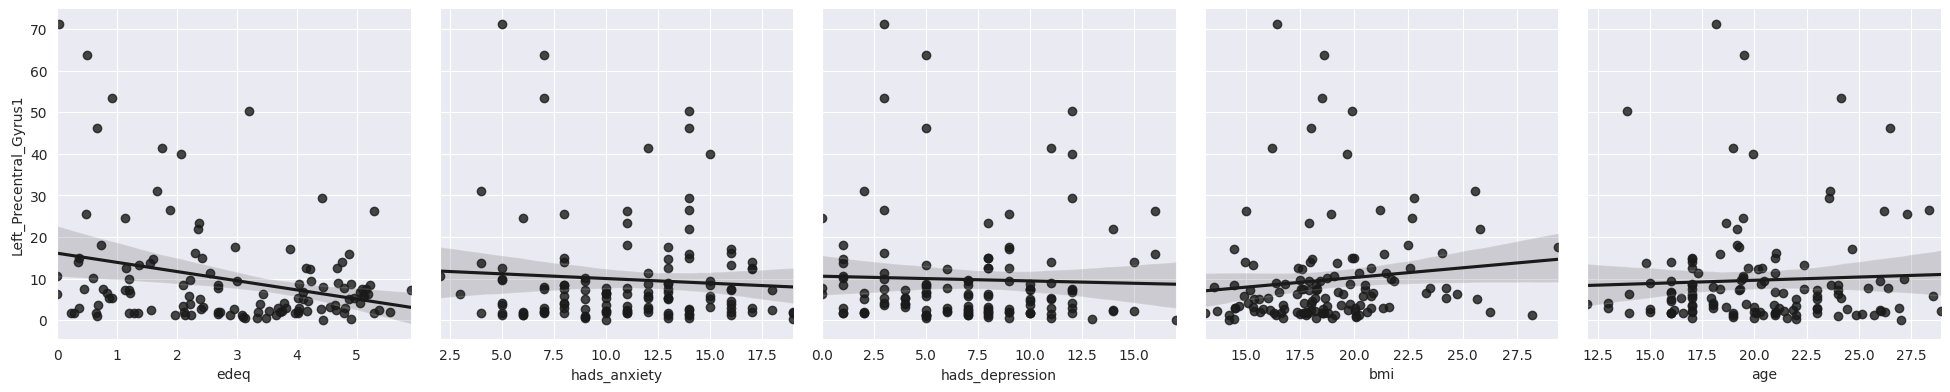

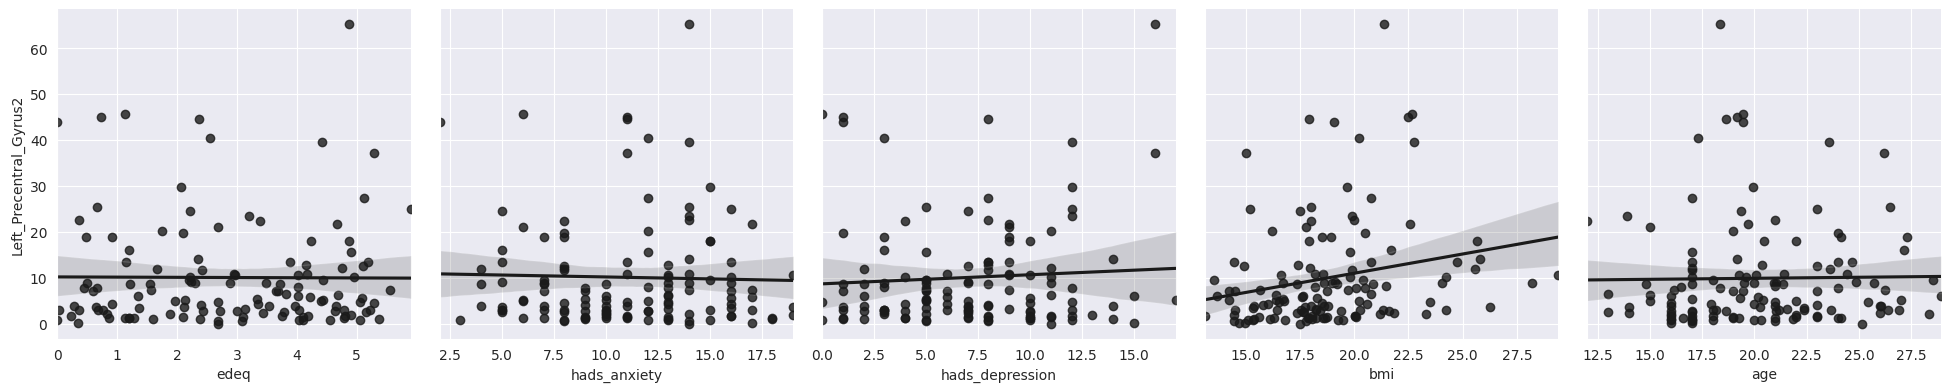

In [ ]:
df = lmm['eft_interaction'][lmm['eft_interaction']['subject'].str.contains('G2')].reset_index(drop=True)
for cluster in lmm['eft_interaction'].drop(['subject', 'time_point', 'edeq', 'hads_anxiety', 'hads_depression', 'bmi', 'age', 'group', 'cluster_trans'],axis=1).columns:
    plots = sns.PairGrid(df, y_vars=[cluster], x_vars=['edeq', 'hads_anxiety', 'hads_depression', 'bmi', 'age'], height=4)
    plots.map(sns.regplot, color=".1")

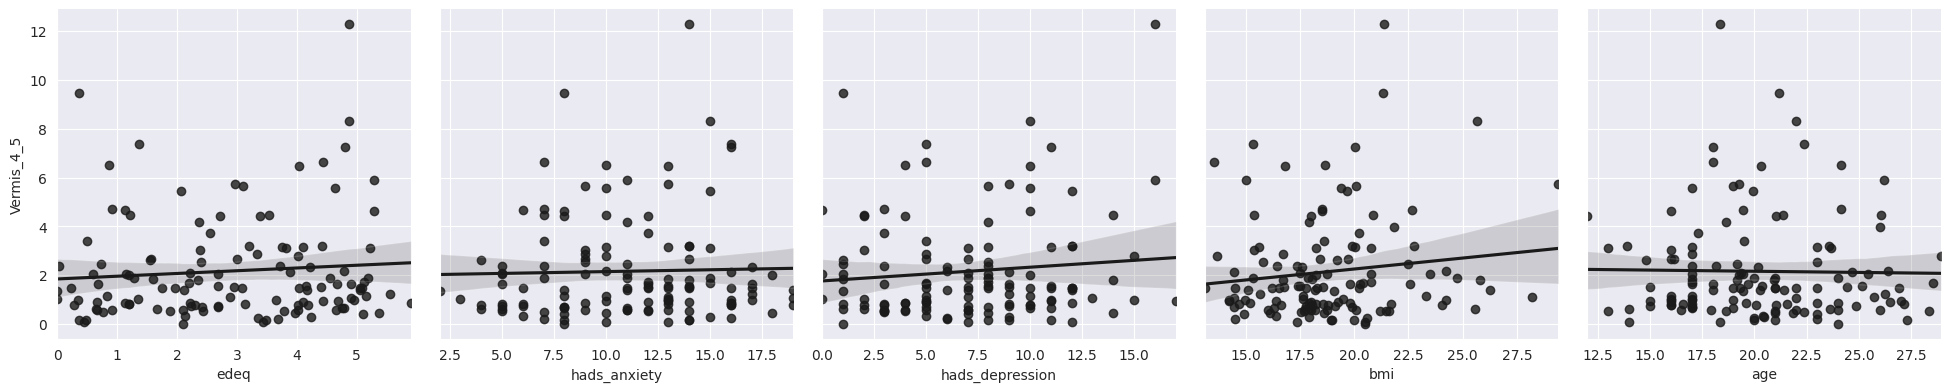

In [ ]:
df = lmm['happy_interaction'][lmm['happy_interaction']['subject'].str.contains('G2')].reset_index(drop=True)
for cluster in lmm['happy_interaction'].drop(['subject', 'time_point', 'edeq', 'hads_anxiety', 'hads_depression', 'bmi', 'age', 'group', 'cluster_trans'],axis=1).columns:
    plots = sns.PairGrid(df, y_vars=[cluster], x_vars=['edeq', 'hads_anxiety', 'hads_depression', 'bmi', 'age',], height=4)
    plots.map(sns.regplot, color=".1")

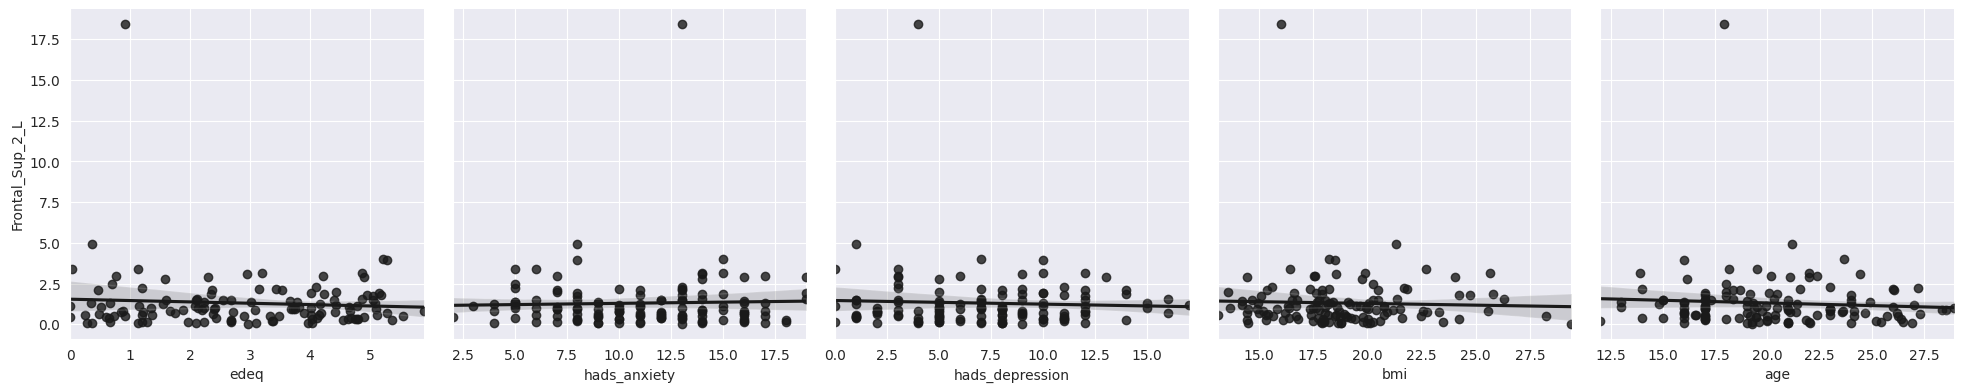

In [ ]:
df = lmm['fear_time'][lmm['fear_time']['subject'].str.contains('G2')].reset_index(drop=True)
for cluster in lmm['fear_time'].drop(['subject', 'time_point', 'edeq', 'hads_anxiety', 'hads_depression', 'bmi', 'age', 'group', 'cluster_trans'],axis=1).columns:
    plots = sns.PairGrid(df, y_vars=[cluster], x_vars=['edeq', 'hads_anxiety', 'hads_depression', 'bmi', 'age',], height=4)
    plots.map(sns.regplot, color=".1")